In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import requests, time, csv, argparse, os, warnings, nltk

from datetime import datetime
from bs4 import BeautifulSoup, NavigableString, Tag
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from tqdm import tqdm

from bertopic import BERTopic
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP

nltk.download('stopwords')
stop = stopwords.words('english')

## Data Collection

In [84]:
def scroll_to_load(driver):
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        for _ in range(10):
            driver.execute_script("window.scrollBy(0, document.documentElement.scrollHeight / 10);")
            time.sleep(2)
        time.sleep(2)
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [85]:
# collection_range = 1

# with webdriver.Chrome(service=Service(ChromeDriverManager().install())) as driver: # driver_version='116.0.5845.110'
#     driver.set_window_size(1024, 600)
#     driver.maximize_window()

#     for page_num in tqdm(range(collection_range, collection_range + 36)):
#         URL = f'https://www.webofscience.com/wos/woscc/summary/54d255b4-96bf-4475-95ea-743313606c41-dfaebb93/relevance/{page_num}'
    
#         driver.get(URL)
#         driver.implicitly_wait(10)
#         scroll_to_load(driver)
        
#         try: driver.find_element(By.XPATH, '//*[@id="onetrust-close-btn-container"]/button').click()
#         except: pass
        
#         time.sleep(2)
        
#         buttons = driver.find_elements(By.CLASS_NAME, 'show-more.show-more-text')
#         for button in buttons:
#             try:
#                 button.click()
#                 time.sleep(0.5)  # 필요하다면 클릭 사이에 잠시 대기
#             except: pass
             
#         paper_lst = driver.find_element(By.CLASS_NAME, 'app-records-list')
        
#         with open(f'html_data/paper_html_{page_num}.txt', 'a') as file:
#             file.write(paper_lst.get_attribute('innerHTML'))

In [86]:
collection_range = 1

with webdriver.Chrome(service=Service(ChromeDriverManager().install())) as driver: # driver_version='116.0.5845.110'
    driver.set_window_size(1024, 600)
    driver.maximize_window()

    for page_num in tqdm(range(collection_range, collection_range + 36)):
        URL = f'https://www.webofscience.com/wos/woscc/summary/54d255b4-96bf-4475-95ea-743313606c41-dfaebb93/relevance/{page_num}'
    
        driver.get(URL)
        driver.implicitly_wait(10)
        scroll_to_load(driver)
        
        try: driver.find_element(By.XPATH, '//*[@id="onetrust-close-btn-container"]/button').click()
        except: pass
        
        time.sleep(2)
        
        buttons = driver.find_elements(By.CLASS_NAME, 'show-more.show-more-text')
        for button in buttons:
            try:
                button.click()
                time.sleep(1)
            except: pass
             
        paper_lst = driver.find_element(By.CLASS_NAME, 'app-records-list')
        
        with open(f'html_data/paper_html_{page_num}.txt', 'a') as file:
            file.write(paper_lst.get_attribute('innerHTML'))

100%|█████████████████| 36/36 [1:16:29<00:00, 127.49s/it]


In [123]:
total_dic = {
    'title': [],
    'abstract': []
}

title_lst, abstract_lst = [], []
for file in tqdm(sorted(os.listdir('./html_data/'))[1:]):
    html = ''
    
    with open(f'./html_data/{file}', 'r') as file:
        html += file.readline()

    soup = BeautifulSoup(html, "html.parser")
    for i in soup.select('app-record'):
        title = i.select_one('app-summary-title')
        abstract = i.select_one('[id^="rec"]')
    
        try:
            title_lst.append(title.text)
        except:
            title_lst.append(None)
            
        try:
            abstract_lst.append(abstract.text)
        except:
            abstract_lst.append(None)

100%|██████████████████| 180/180 [00:02<00:00, 71.04it/s]


In [134]:
new_df = pd.DataFrame({'title': title_lst, 'abstract': abstract_lst})
print(new_df.shape)
new_df.head()

(2415, 2)


,title,abstract
0,Wearable Augmented Reality System using Gaze I...,Undisturbed interaction is essential to provid...
1,QR Code Alteration for Augmented Reality Inter...,"QR code, for its recognition robustness and da..."
2,Near and Far Interaction for Augmented Reality...,The implementation of augmented reality in nat...
3,Augmented Reality Interaction on Property Deve...,Sales property developer interacted with their...
4,Assisted Human-Robot Interaction for Industry ...,None


In [141]:
new_df.to_csv('title_abstract_df.csv')

In [132]:
total_df = pd.read_csv('total_data.csv', index_col=0)
print(total_df.shape)
total_df.head()

(4014, 3)


,title,date,j_c_name
0,Integrating Augmented Reality to Enhance Expre...,IEEE International Symposium on Mixed and Augm...,2014 IEEE INTERNATIONAL SYMPOSIUM ON MIXED AND...
1,Comparing Single-modal and Multimodal Interact...,19th IEEE International Symposium on Mixed and...,ADJUNCT PROCEEDINGS OF THE 2020 IEEE INTERNATI...
2,Multimodal Interaction in Augmented Reality,"IEEE International Conference on Systems, Man,...","2017 IEEE INTERNATIONAL CONFERENCE ON SYSTEMS,..."
3,"Virtual, Augmented, and Mixed Reality for Huma...",14th ACM/IEEE International Conference on Huma...,HRI '19: 2019 14TH ACM/IEEE INTERNATIONAL CONF...
4,Interaction Design in Augmented Reality on the...,9th International Congress on Image and Signal...,2016 9TH INTERNATIONAL CONGRESS ON IMAGE AND S...


In [139]:
title_df = pd.DataFrame(pd.concat([total_df['title'], new_df['title']]).drop_duplicates()).reset_index(drop=True)
print(title_df.shape)
title_df.head()

(4382, 1)


,title
0,Integrating Augmented Reality to Enhance Expre...
1,Comparing Single-modal and Multimodal Interact...
2,Multimodal Interaction in Augmented Reality
3,"Virtual, Augmented, and Mixed Reality for Huma..."
4,Interaction Design in Augmented Reality on the...


In [140]:
title_df.to_csv('title_df.csv')

## BERTopic (Topic Modeling)

In [143]:
df_title = pd.read_csv('title_df.csv', index_col=0)
df_title = df_title.drop_duplicates('title').reset_index(drop=True)
df_title['title'] = df_title['title'].str.lower()
df_title['title_without_stopwords'] = df_title['title'].astype('str').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(df_title.shape)
df_title.head()

In [144]:
df_abstract = pd.read_csv('/content/title_abstract_df.csv', index_col=0).dropna()
df_abstract['abstract'] = df_abstract['abstract'].str.lower()
df_abstract['abstract_without_stopwords'] = df_abstract['abstract'].astype('str').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(df_abstract.shape)
df_abstract.head()

In [145]:
title_docs = df_title['title_without_stopwords'].to_list()
print(len(title_docs))

abstract_docs = df_abstract['abstract_without_stopwords'].to_list()
print(len(abstract_docs))

In [146]:
def bertopic_visualization(docs, n_neighbor, n_component, min_dist):
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=False)

    topic_model = BERTopic().fit(docs, embeddings)
    reduced_embeddings = UMAP(n_neighbors=n_neighbor, n_components=n_component, min_dist=min_dist, metric='cosine').fit_transform(embeddings)

    return topic_model, reduced_embeddings

In [147]:
model, reduced_embeddings = bertopic_visualization(title_docs, 15, 2, 0.25)
model.visualize_documents(title_docs, reduced_embeddings=reduced_embeddings, hide_annotations=True)

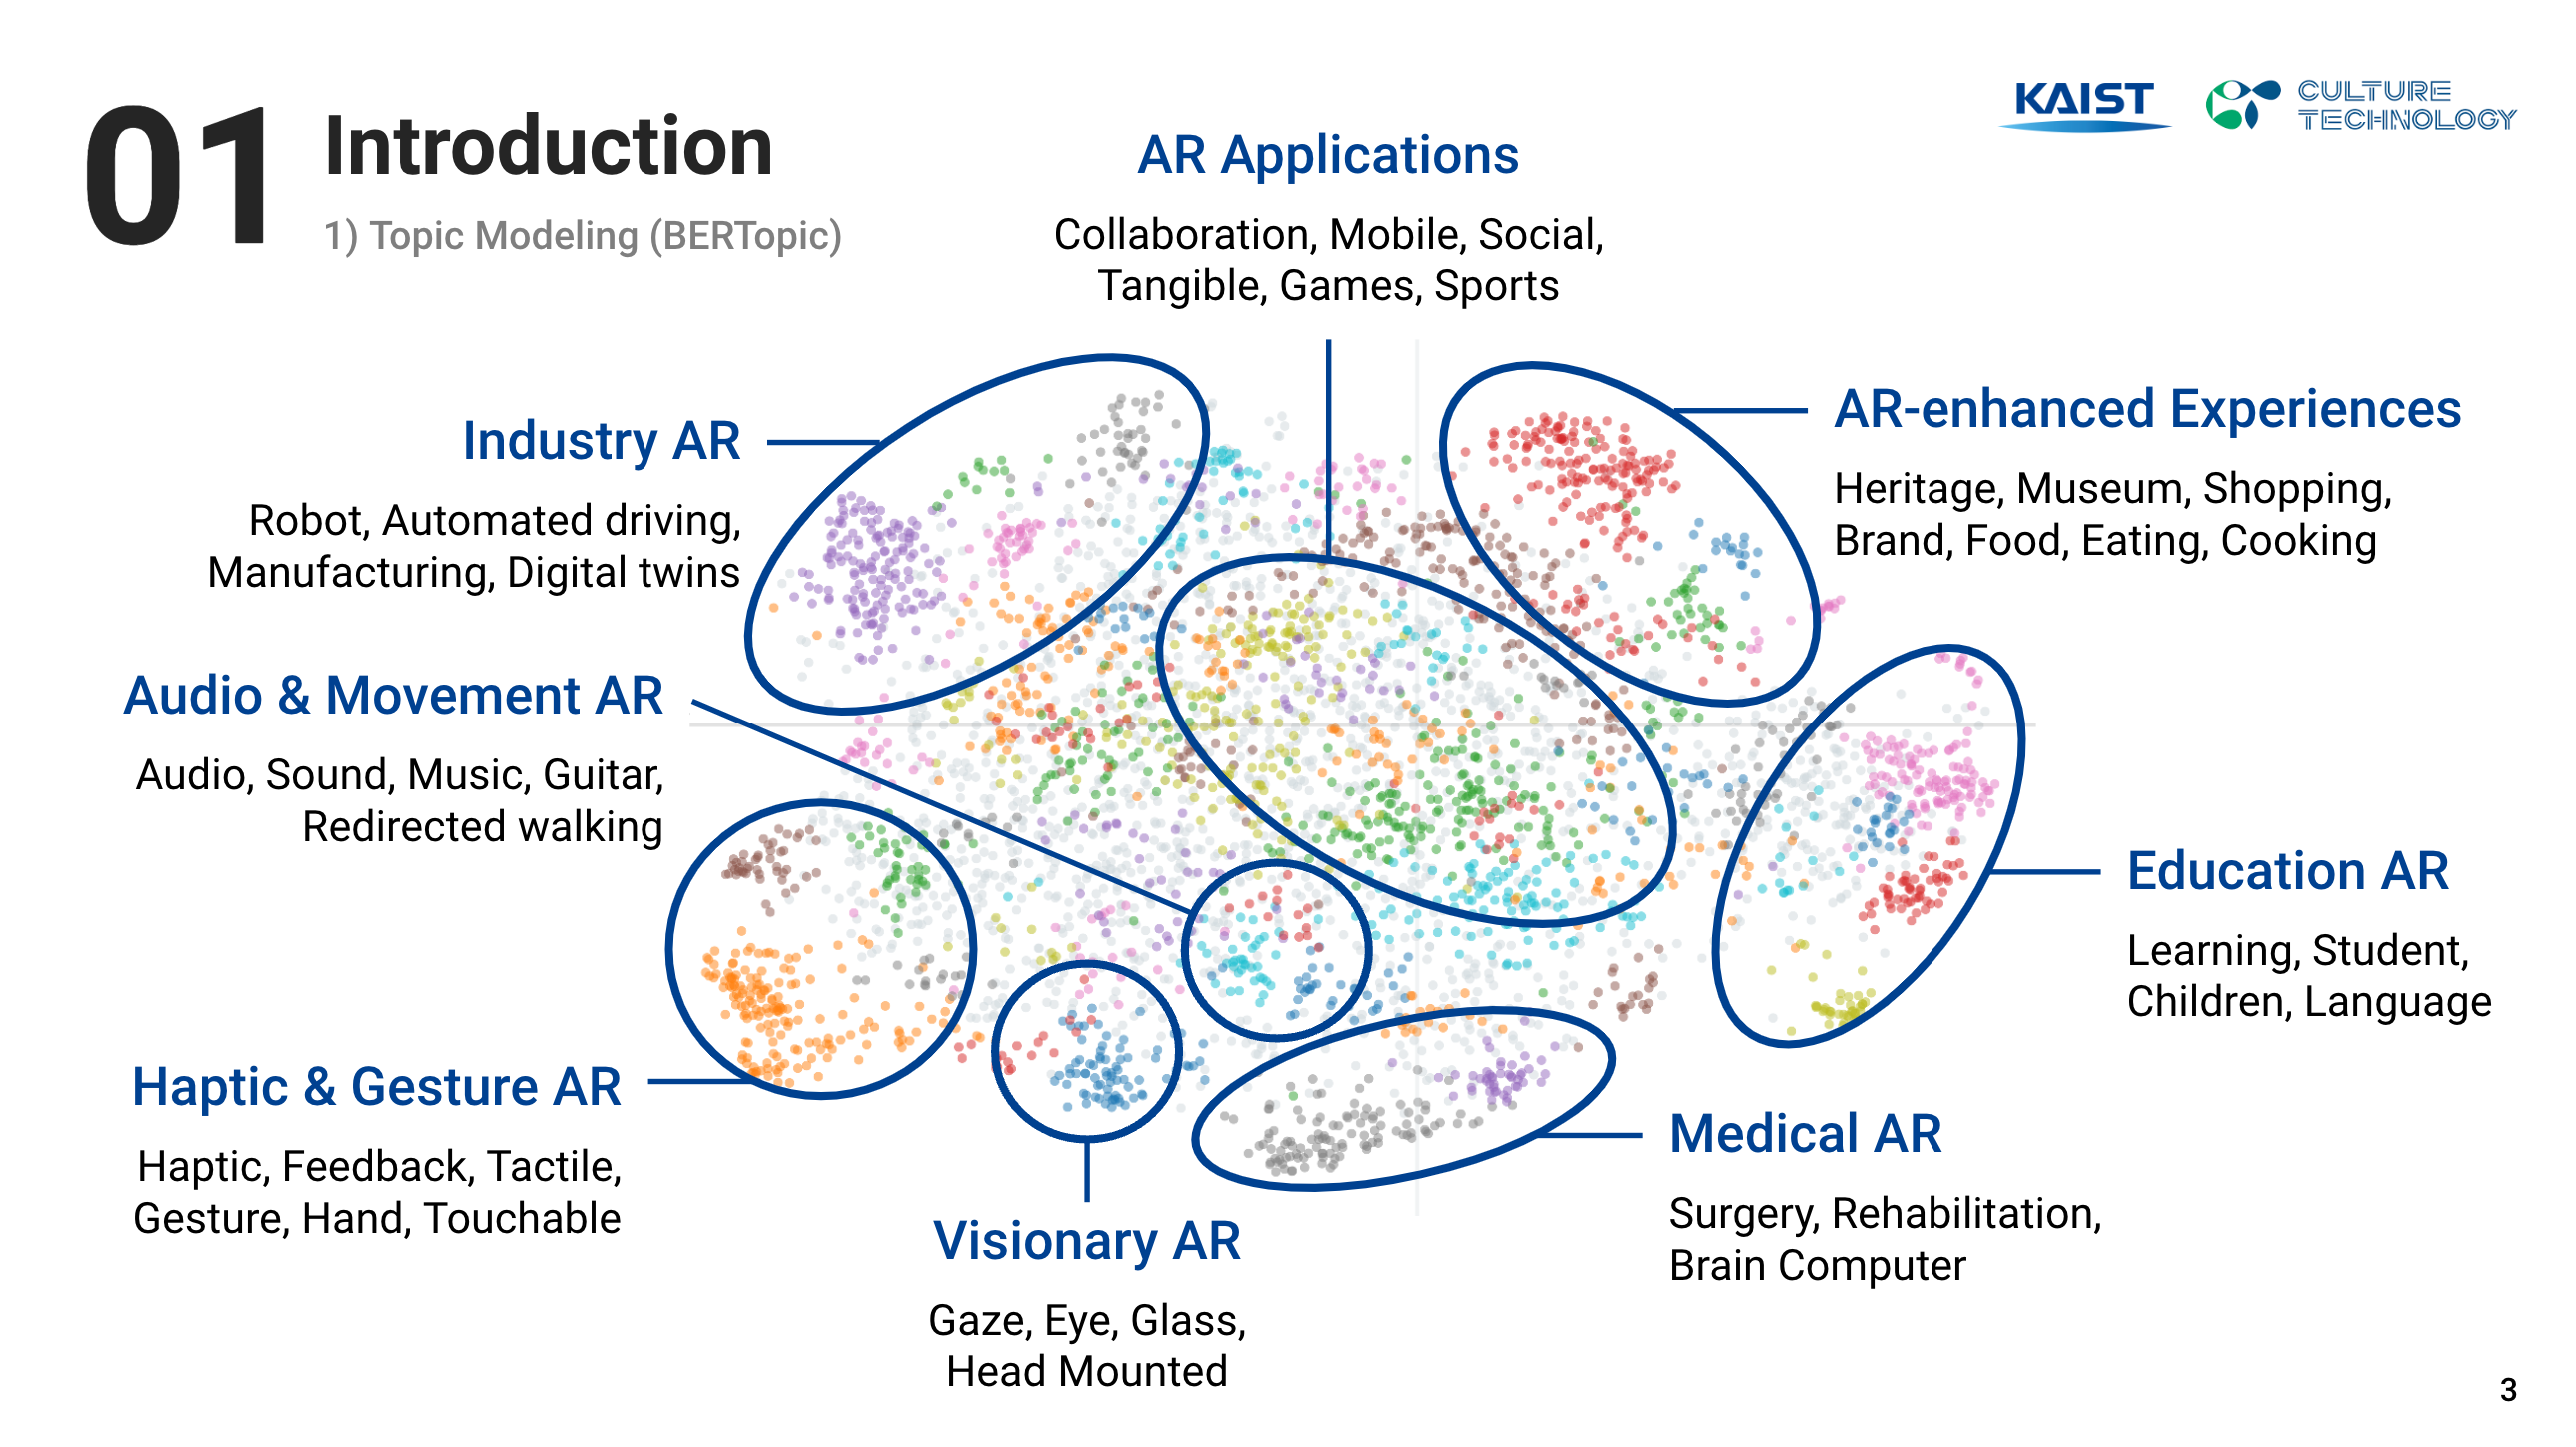

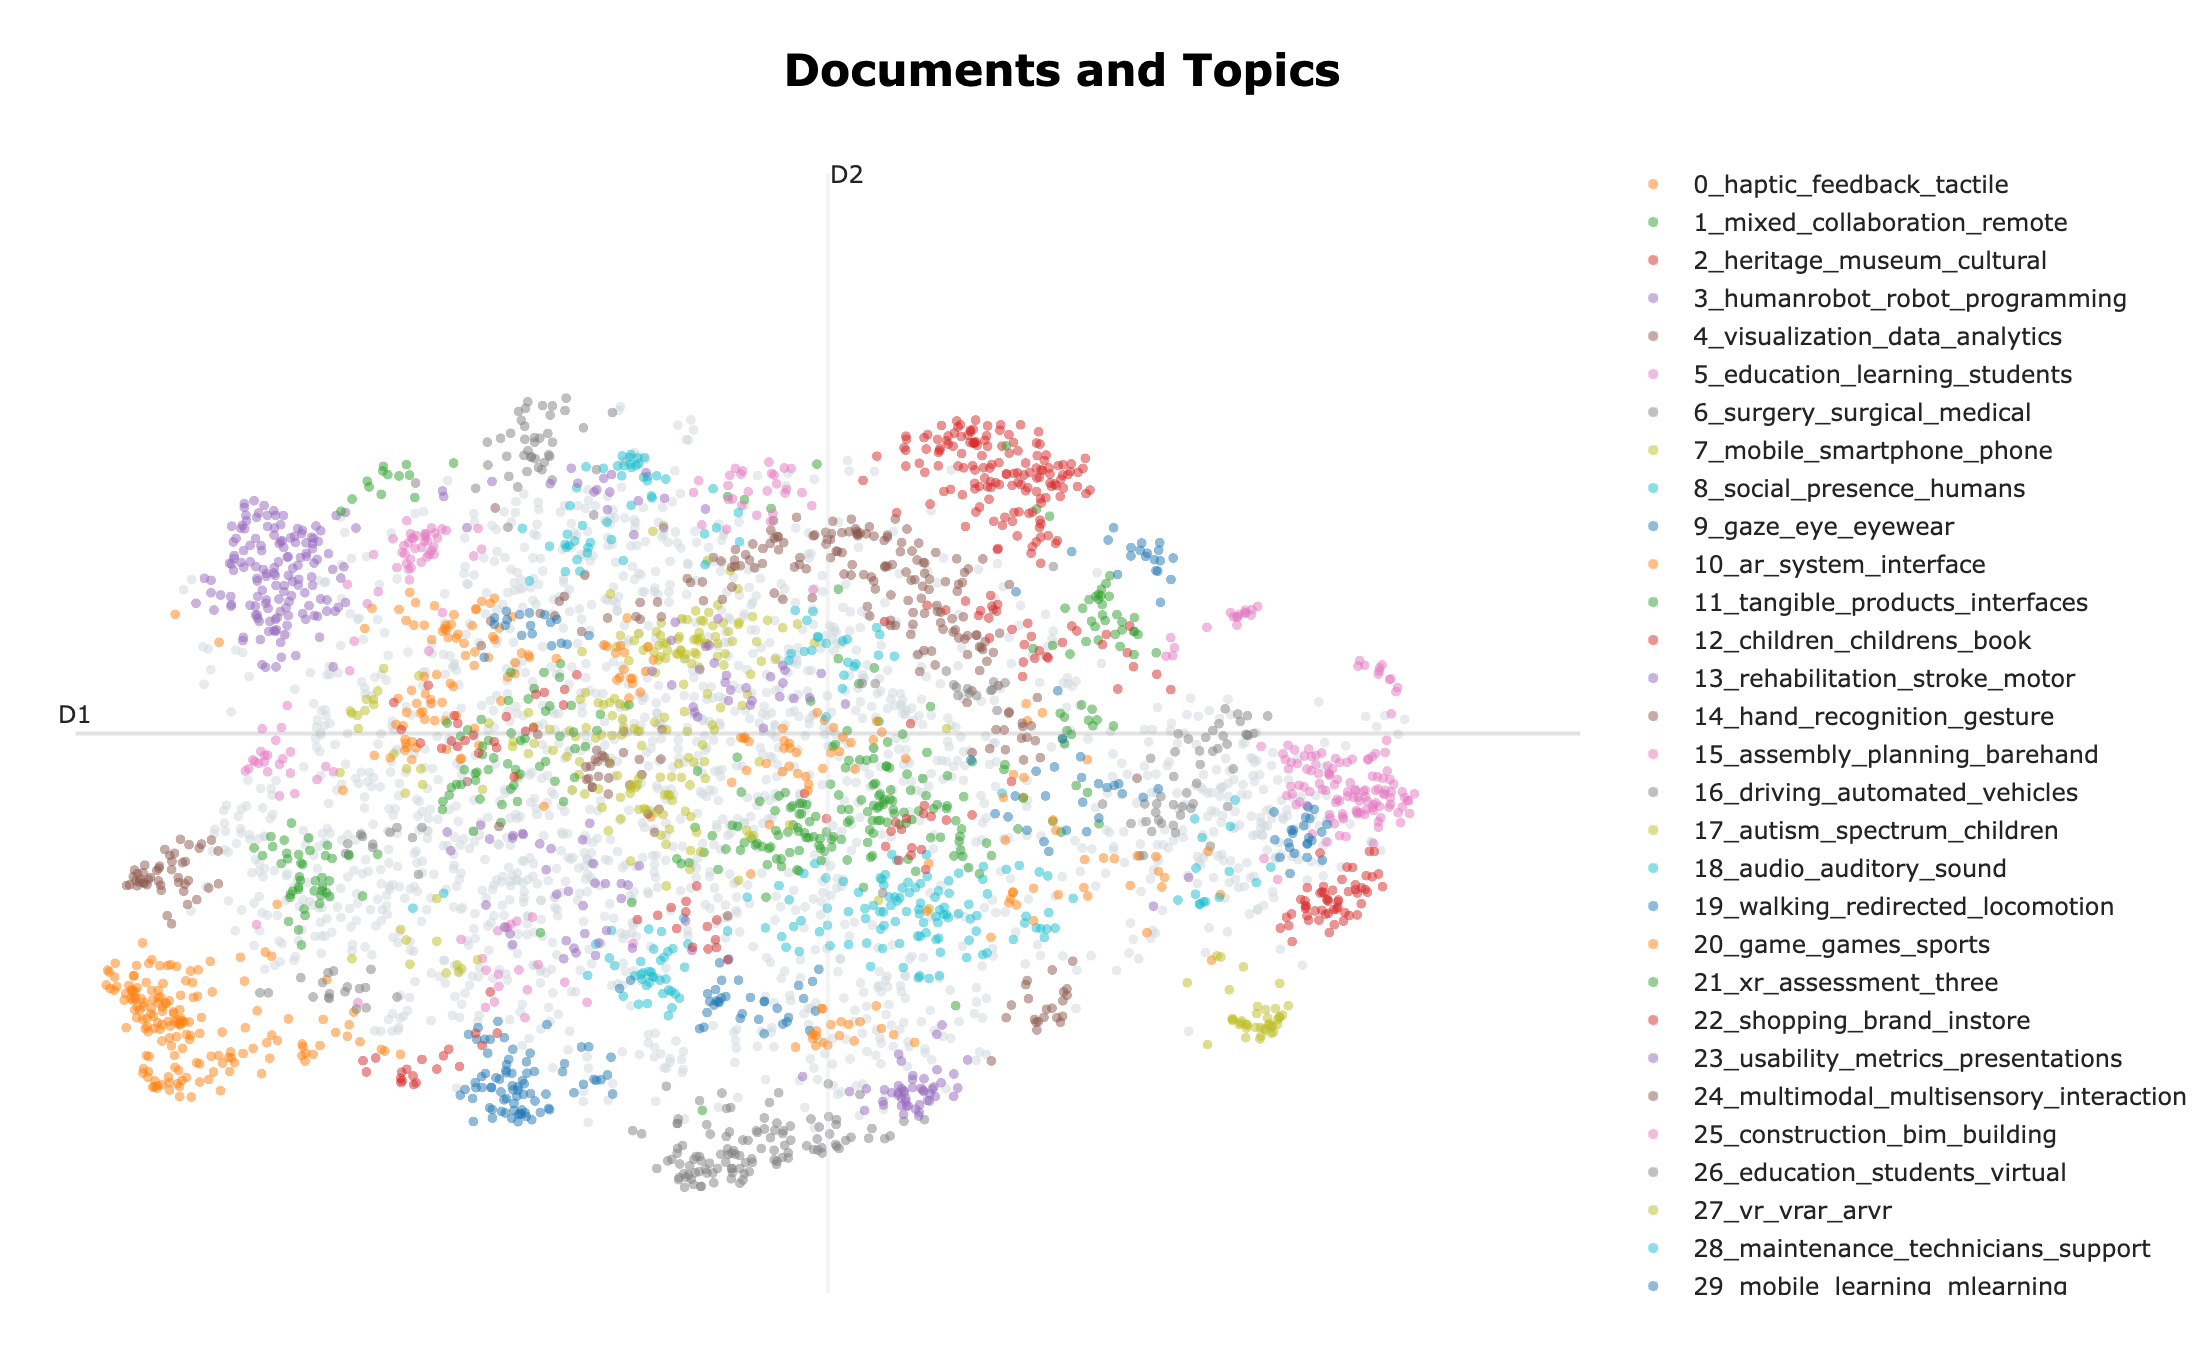